## https://medium.com/analytics-vidhya/interative-map-with-osm-directions-and-networkx-582c4f3435bc

In [20]:
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, mapping
import geopandas as gpd
from ipyleaflet import *

In [ ]:
safegraph = pd.read_csv(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\2020_03_SafeGraph_Patterns\2020-03-patterns\core_poi-patterns.csv", index_col=0)

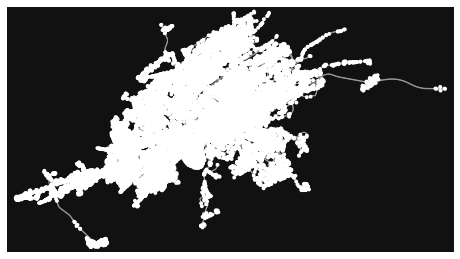

In [21]:
place_name = "Knoxville, Tennessee, United States"
graph = ox.graph_from_place(place_name)
fig, ax = ox.plot_graph(graph)

In [22]:
nodes, edges = ox.graph_to_gdfs(graph)
nodes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
202779539,35.923360,-83.874067,3,NaN,NaN,POINT (-83.87407 35.92336)
202779542,35.922283,-83.873573,3,NaN,NaN,POINT (-83.87357 35.92228)
202779582,35.984343,-83.923735,4,NaN,NaN,POINT (-83.92373 35.98434)
202779584,35.984006,-83.922297,4,NaN,NaN,POINT (-83.92230 35.98401)
202779587,35.983759,-83.921248,3,NaN,NaN,POINT (-83.92125 35.98376)
...,...,...,...,...,...,...
8536839291,35.977899,-83.895250,1,NaN,NaN,POINT (-83.89525 35.97790)
8548608825,35.981648,-83.885902,3,NaN,NaN,POINT (-83.88590 35.98165)
8548608835,35.981083,-83.885043,1,NaN,NaN,POINT (-83.88504 35.98108)


In [25]:
center = (35.9606, -83.9207)
m = Map(center=center, basemap=basemaps.CartoDB.Positron, zoom=12)
m

Map(center=[35.9606, -83.9207], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [27]:
#style for the destination marker
to_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='red',
    spin=False
)
from_marker = Marker(location=center)
to_marker = Marker(location=center, icon=to_marker_style)

def set_nearest_node(marker):
 marker.nearest_node = ox.get_nearest_node(graph, marker.location)
 return

In [28]:
path_layer_list = []
def handle_change_location(event, marker):
    event_owner = event['owner']
    event_owner.nearest_node = ox.get_nearest_node(graph, event_owner.location)
    marker.nearest_node = ox.get_nearest_node(graph, marker.location)
    
    shortest_path = nx.dijkstra_path(graph, event_owner.nearest_node, marker.nearest_node, 
                                     weight='length')
    
    if len(path_layer_list) == 1:
        m.remove_layer(path_layer_list[0])
        path_layer_list.pop()
    
    shortest_path_points = nodes.loc[shortest_path]
    path = gpd.GeoDataFrame([LineString(shortest_path_points.geometry.values)], columns=['geometry'])
    path_layer = GeoData(geo_dataframe=path, style={'color':'black', 'weight':2})
    m.add_layer(path_layer)
    path_layer_list.append(path_layer)

In [30]:
m.add_layer(from_marker)
m.add_layer(to_marker)
set_nearest_node(from_marker)
set_nearest_node(to_marker)
m

Map(bottom=412103.0, center=[35.9606, -83.9207], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

In [29]:
from_marker.observe(lambda event: handle_change_location(event, to_marker), 'location')
to_marker.observe(lambda event: handle_change_location(event, from_marker), 'location')

In [18]:
mx, my = m(stores["longitude"].values, stores["latitude"].values)
pos = {}
for count, elem in enumerate (stores["customer_Title"]):
    pos[elem] = (mx[count], my[count])

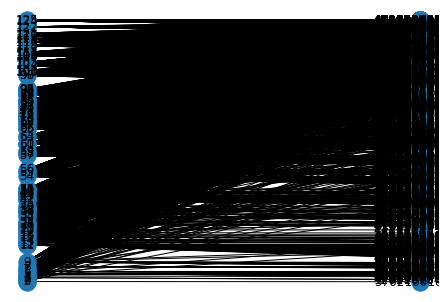

In [19]:
pos = {node:[0, i] for i,node in enumerate(safegraph_unpack["StoreID"])}
pos.update({node:[1, i] for i,node in enumerate(safegraph_unpack['visitor_home_cbg'])})
nx.draw(visits, pos, with_labels=False)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
nx.draw_networkx_labels(visits, pos)

plt.show()

In [23]:
import folium

### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
### Functions for simple mapping using folium 
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def make_map_plot(df_, 
                  plot_limit=3000, 
                  radius_col=None, 
                  radius_mod=100, 
                  color='black', 
                  fill_color='red', 
                  fill_opacity = 0.2, 
                  pop_up_col=None,
                  tooltip = 'Click for more info.', 
                  zoom_start=4,
                  tiles = 'OpenStreetMap', 
                  map_width = 700,
                  map_height = 400,
                  marker_type= 'circle', 
                  map_plot=None, 
                  verbose=False):
    # Parameters:
      # df_ is a pandas dataframe. It requires a column called "latitude" and a column called "longitude". 
      # radius_col is a column_name or None. If None, every point is given a fixed radius. 
          # Otherwise, the value in the column radius_col is used as the radius. 
      # radius_mod is to scale your radius units to correspond to units on your map.
      # zoom_start is the scale of the map. Larger numbers = higher resolution.
      # color, fill_color, fill_opacity are marker parameters, see others: https://leafletjs.com/reference-1.3.4.html#path 
      # tiles determines the base layer. Open source options include 'OpenStreetMap', 'Stamen Terrain', 'Stamen Toner'
      # map_width and map_height determine the size of the map image (in pixels)
      # marker_type determines what type of marker is being drawn on the map. Options: 'circle' or 'normal'
    
    # check valid inputs
    valid_inputs = {'marker_type' : {'val' : marker_type, 'valids' : ['circle', 'normal']},
                    'tiles' :  {'val' : tiles, 'valids': ['OpenStreetMap', 'Stamen Terrain', 'Stamen Toner', 'Mapbox Bright', 'Mapbox Control Room']},
                    'radius_col' : {'val' : radius_col, 'valids' : [None] + [col for col in df_.columns if pd.api.types.is_numeric_dtype(df_[col])]}}
    for param, param_valid_dict in valid_inputs.items():
        if(param_valid_dict['val'] not in param_valid_dict['valids']):
            raise Exception("Invalid parameter input for '{0}'. Valid options are {1}. input value was '{2}' .".format(param, param_valid_dict['valids'], param_valid_dict['val']))   

    # create basemap
    if(not map_plot):
        map_plot = folium.Map(width=map_width,
                            height=map_height,
                            location=[df_.latitude.mean(), df_.longitude.mean()],
                            tiles=tiles,
                            zoom_start=zoom_start,
                            control_scale = True)

    # add markers
    counter = 0
    for index, row in df_.iterrows():
        counter+=1
        if(marker_type=='circle'):
            add_circle_marker_to_map(map_plot, row, radius_col, radius_mod, color, fill_color, fill_opacity, pop_up_col, tooltip)
        elif(marker_type=='normal'):
            add_marker_to_map(map_plot, row, pop_up_col, tooltip)
        if(counter>plot_limit): break
    if(verbose): print("Plotted {0} locations".format(counter))
    return(map_plot)


def add_marker_to_map(map_plot, row, pop_up_col, tooltip):
    folium.Marker([row.latitude, row.longitude],
                        popup= row[pop_up_col] if pop_up_col else None,
                        tooltip=tooltip if pop_up_col else None,
                   ).add_to(map_plot)
    return(None)


def add_circle_marker_to_map(map_plot, row, radius_col, radius_mod, color, fill_color, fill_opacity, pop_up_col, tooltip):
    folium.CircleMarker([row.latitude, row.longitude],
                        radius= row[radius_col]/radius_mod if radius_col else 2,
                        color = color,
                        fill_color = fill_color,
                        weight=0.5,
                        fill_opacity= fill_opacity,
                        popup= row[pop_up_col] if pop_up_col else None,
                        tooltip=tooltip if pop_up_col else None,
                   ).add_to(map_plot)
    return(None)

In [12]:
make_map_plot(safegraph, fill_color='red', fill_opacity=1)